# Notebook where a single polygon file of Netherlands is loaded from google drive, visualize the same. Followed by generating satellite images from Copernicus using the polygon information. More an exploration!

# Install required libraries


In [1]:
!pip -q install geopandas
!pip -q install geojson
!pip -q install folium
!pip -q install geemap
!pip -q install rasterio
!pip -q install tqdm

In [2]:
!pip install earthengine-api --upgrade

     |████████████████████████████████| 228 kB 4.2 MB/s 
  Created wheel for earthengine-api: filename=earthengine_api-0.1.280-py3-none-any.whl size=259671 sha256=afbf04b7a5783aefb2225b4e5d3f768000ef42b5e57a423e7063494e4290750a
  Stored in directory: /root/.cache/pip/wheels/21/17/28/c180a7798edb656619564763cb9e52b4c4d9e0503bd2945e50
Successfully built earthengine-api
  Attempting uninstall: earthengine-api
    Found existing installation: earthengine-api 0.1.278
    Uninstalling earthengine-api-0.1.278:
      Successfully uninstalled earthengine-api-0.1.278


# Import and Setup

In [2]:
%matplotlib inline
import time 
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import geojson
import requests
import geopandas as gpd
import numpy as np

import rasterio as rio
from rasterio.plot import show
import rasterio.mask

from rasterio import windows
from shapely.geometry import box
import pandas as pd

import ee
import geemap
import geemap.eefolium as emap
import folium

# Mount drive

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Authenticate Google earth engine

In [4]:
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=LHREhv7EgrwR6Y7fzxPAlXbFPR9KyMABqEloJlIP9vY&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWiiNIvlc_kSf3lo6fyebefo78d2UIRkZU0NNNjdaVg5ZAzpz7mCRmY

Successfully saved authorization token.


# Fetch Netherlands shape file from drive

In [6]:
#netherlands_provinces = './drive/My Drive/Netherlands/netherlands-singlepolygon.geojson'
netherlands_provinces = './drive/My Drive/Netherlands/NL-new-singlepolygon.geojson'

# View the data

In [7]:
provinces = gpd.read_file(netherlands_provinces)
provinces.head(10)

,id,id_0,iso,name_0,id_1,name_1,hasc_1,ccn_1,cca_1,type_1,engtype_1,nl_name_1,varname_1,geometry
0,st293bj4601.1,158,NLD,Netherlands,1,Drenthe,NL.DR,0,None,Provincie,Province,None,None,"POLYGON ((6.50131 53.19841, 6.50429 53.19749, ..."
1,st293bj4601.10,158,NLD,Netherlands,10,Overijssel,NL.OV,0,None,Provincie,Province,None,None,"POLYGON ((6.13809 52.84380, 6.15725 52.83023, ..."
2,st293bj4601.2,158,NLD,Netherlands,2,Flevoland,NL.FL,0,None,Provincie,Province,None,None,"POLYGON ((5.44521 52.55581, 5.43211 52.53638, ..."
3,st293bj4601.2,158,NLD,Netherlands,2,Flevoland,NL.FL,0,None,Provincie,Province,None,None,"POLYGON ((5.44521 52.55581, 5.45261 52.56209, ..."
4,st293bj4601.2,158,NLD,Netherlands,2,Flevoland,NL.FL,0,None,Provincie,Province,None,None,"POLYGON ((5.85673 52.55246, 5.85966 52.54976, ..."
5,st293bj4601.2,158,NLD,Netherlands,2,Flevoland,NL.FL,0,None,Provincie,Province,None,None,"POLYGON ((5.46890 52.56568, 5.47186 52.56837, ..."
6,st293bj4601.2,158,NLD,Netherlands,2,Flevoland,NL.FL,0,None,Provincie,Province,None,None,"POLYGON ((5.75513 52.83910, 5.77305 52.82814, ..."
7,st293bj4601.3,158,NLD,Netherlands,3,Friesland,NL.FR,0,None,Provincie,Province,None,Frise|Frisia|Frísia,"POLYGON ((5.24917 53.25458, 5.24917 53.25431, ..."
8,st293bj4601.3,158,NLD,Netherlands,3,Friesland,NL.FR,0,None,Provincie,Province,None,Frise|Frisia|Frísia,"POLYGON ((5.13750 53.29930, 5.13750 53.29903, ..."
9,st293bj4601.3,158,NLD,Netherlands,3,Friesland,NL.FR,0,None,Provincie,Province,None,Frise|Frisia|Frísia,"POLYGON ((5.07028 53.30708, 5.07028 53.30680, ..."


# Plot the geojson file

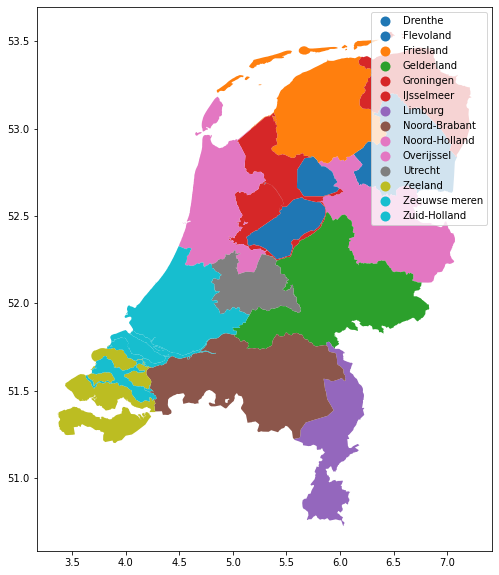

In [8]:
fig, ax = plt.subplots(1, figsize=(10, 10))
provinces.plot('name_1', legend=True, ax=ax)
plt.show()

In [9]:
fig, ax = plt.subplots(1,2 ,figsize=(20, 10))
caribbean_net = provinces[provinces['name_1'] == 'Caribbean Netherlands']
mainland = provinces[provinces['name_1'] != 'Caribbean Netherlands']
caribbean_net.plot('name_1',
                    legend=True,
                    ax = ax[0],
                    legend_kwds={'loc':'lower right'})
mainland.plot('name_1', 
               legend=True,
               ax=ax[1], 
               legend_kwds={'loc':'lower right'})
plt.show()

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


ValueError: ignored

ValueError: ignored

# Fetch unique province names

In [15]:
provinces['name_1'].unique()

array(['Drenthe', 'Overijssel', 'Flevoland', 'Friesland', 'Gelderland',
       'Groningen', 'IJsselmeer', 'Limburg', 'Noord-Brabant',
       'Noord-Holland', 'Utrecht', 'Zeeland', 'Zeeuwse meren',
       'Zuid-Holland'], dtype=object)

# Fetch centroids - Excluding Carribean Netherlands

In [ ]:
province_centroids = {}
for province in provinces.name_1.unique():
  if province == 'Caribbean Netherlands':
    continue
  centroid = provinces[provinces.name_1 == province].centroid.iloc[0].coords[0]
  province_centroids[province] = centroid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """


In [ ]:
province_centroids

{'Drenthe': (6.618435328443195, 52.86248485884109),
 'Flevoland': (5.51516187250977, 52.55038256959785),
 'Friesland': (4.961421807772998, 53.25725959786181),
 'Gelderland': (5.939113813071744, 52.06173797894203),
 'Groningen': (6.742933755277094, 53.216016405167544),
 'Limburg': (5.933870029395927, 51.209227330169604),
 'North Brabant': (5.18494954133083, 51.561177684514796),
 'North Holland': (4.940456242227738, 52.90861285788344),
 'Overijssel': (6.441722302026566, 52.44455764726092),
 'South Holland': (4.462113952984123, 51.937835367494145),
 'Utrecht': (5.163824116953257, 52.08425068172728),
 'Zeeland': (3.6268671653097924, 51.393910679036985)}

# Fetch Limburg related polygon details

In [16]:
limburg = provinces[provinces.name_1 == 'Limburg']

In [17]:
limburg['geometry']

22    POLYGON ((5.90046 51.77842, 5.90907 51.77164, ...
Name: geometry, dtype: geometry

# Generate images from Copernicus

In [23]:
# Fetching co-ordinates of Limburg 
centroid = limburg.centroid.iloc[0].coords[0]
minx = limburg.bounds['minx'].values[0]-.4
miny = limburg.bounds['miny'].values[0]-.4
maxx = limburg.bounds['maxx'].values[0]+.4
maxy = limburg.bounds['maxy'].values[0]+.4
geometry = ee.Geometry.Rectangle([minx, miny, maxx, maxy])
#geometry = ee.Geometry.Rectangle([51.22091, 5.56605, 51.22194, 5.57173])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [25]:
geometry.getInfo()

{'coordinates': [[[5.1705862, 50.32349167],
   [6.6263789200000005, 50.32349167],
   [6.6263789200000005, 52.17949142],
   [5.1705862, 52.17949142],
   [5.1705862, 50.32349167]]],
 'type': 'Polygon'}

# Checking centroid is correcty

In [26]:
import folium

# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'

print('Folium version: ' + folium.__version__)

def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = EE_TILES.format(**v),
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

Folium version: 0.12.1


In [30]:
image_collection = (ee.ImageCollection("COPERNICUS/S2")
              # Select the Red, Green and Blue image bands, as well as the cloud masking layer.
              .select(['B4', 'B3', 'B2'])
              # Filter for images within a given date range.
              .filter(ee.Filter.date('2020-01-01', '2020-03-31'))
              # Filter for images that overlap with the assigned geometry.
              .filterBounds(geometry)
              # Filter for images that have less then 10% cloud coverage.
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
             )

image_count = image_collection.size().getInfo()
image_list = image_collection.toList(image_count)
image = ee.Image(image_list.get(0))
image = image.visualize(bands=['B4', 'B3', 'B2'],
                       min=[0.0, 0.0, 0.0],
                       max=[0.3, 0.3, 0.3]
                      )

In [31]:
center = geometry.centroid().getInfo()['coordinates']
center.reverse()
Mapdisplay(center,{'landsat':image.getMapId()},zoom_start=10 )

# Explore image_collection and it's properties, corresponding data

In [ ]:
image_collection.first().propertyNames().getInfo()

In [ ]:
image_collection.aggregate_array('SPACECRAFT_NAME').getInfo()

In [ ]:
image_collection.aggregate_array('WATER_PERCENTAGE').getInfo()

In [ ]:
image_collection.aggregate_array('PRODUCT_ID').getInfo()

In [ ]:
image_collection.aggregate_count('system:id').getInfo()

39

In [ ]:
image_collection.count().getInfo()

In [ ]:
image_collection.size().getInfo()

39

# Work In Progress: Select RGB bands to start with

In [ ]:
rgb_image = image_collection.select('B4', 'B3', 'B2')

# Export images to drive - Doesn't seem to export though !


In [ ]:


# Export Image
#task = ee.batch.Export.image.toDrive(image, **task.config)
#task.start()
#while task.active():
#  print('Polling for task (id: {}).'.format(task.id))
#  time.sleep(5)

In [ ]:
image_count = image_collection.size().getInfo()
image_list = image_collection.toList(image_count)


task_config = {'region' : geometry.coordinates().getInfo(),
                'folder' : 'ee_images',
                'scale' : 10,
                'crs':'EPSG:4326',
                'fileFormat' : 'GeoTIFF'}

# For test purpose, generating just 2 images
# Once things work, will change to image_count
for i in range(0, 2):
    image = ee.Image(image_list.get(i))
    name = image.get('system:index').getInfo()
    print('Name: ', name)

    task = ee.batch.Export.image.toDrive(image, #current image
                                         "image_" + str(i), #name of file
                                        **task_config)
    task.start()
    print(task.status())
    while task.active():
      print('Polling for task (id: {}).'.format(task.id))
      time.sleep(20)

Name:  20200101T105441_20200101T105437_T31UGS
{'state': 'READY', 'description': 'image_0', 'creation_timestamp_ms': 1629998066151, 'update_timestamp_ms': 1629998066151, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_IMAGE', 'id': 'PJZXWJ7K62WACABYHZE6HCSE', 'name': 'projects/earthengine-legacy/operations/PJZXWJ7K62WACABYHZE6HCSE'}
Polling for task (id: PJZXWJ7K62WACABYHZE6HCSE).
Polling for task (id: PJZXWJ7K62WACABYHZE6HCSE).
Polling for task (id: PJZXWJ7K62WACABYHZE6HCSE).
Polling for task (id: PJZXWJ7K62WACABYHZE6HCSE).
Polling for task (id: PJZXWJ7K62WACABYHZE6HCSE).
Polling for task (id: PJZXWJ7K62WACABYHZE6HCSE).
Polling for task (id: PJZXWJ7K62WACABYHZE6HCSE).
Polling for task (id: PJZXWJ7K62WACABYHZE6HCSE).
Polling for task (id: PJZXWJ7K62WACABYHZE6HCSE).
Polling for task (id: PJZXWJ7K62WACABYHZE6HCSE).
Polling for task (id: PJZXWJ7K62WACABYHZE6HCSE).
Polling for task (id: PJZXWJ7K62WACABYHZE6HCSE).
Polling for task (id: PJZXWJ7K62WACABYHZE6HCSE).
Polling for task (id: PJZXWJ7K6

# Load an exported image and visualize

In [ ]:
from matplotlib import pyplot

image = './drive/My Drive/ee_images/image_0.tif'

raster_image = rasterio.open(image)

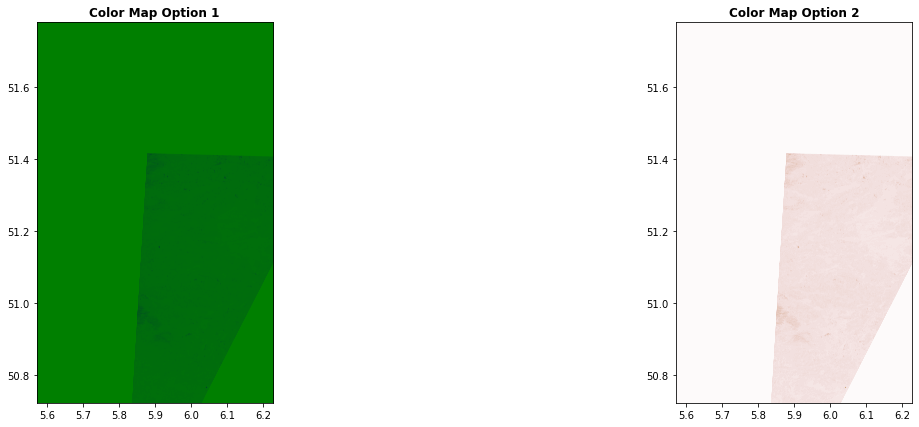

In [ ]:
fig, (axr, axg) = pyplot.subplots(1,2, figsize=(21,7))
show((raster_image, 3), ax=axr, cmap='ocean', title='Color Map Option 1')
show((raster_image, 2), ax=axg, cmap='gist_earth_r', title='Color Map Option 2')
pyplot.show()

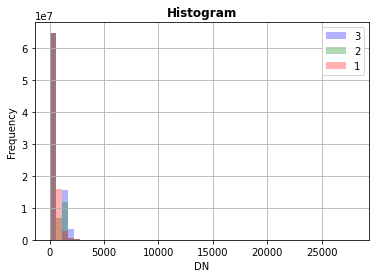

In [ ]:
from rasterio.plot import show_hist

show_hist(raster_image, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram")

# Visualizing using folium

In [5]:
# Function to add layer funct to folium map

def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
      tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=name,
      overlay=True,
      control=True
  ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

In [7]:
netherlands_provinces = './drive/My Drive/Netherlands/NL-new-singlepolygon.geojson'
provinces = gpd.read_file(netherlands_provinces)
limburg = provinces[provinces.name_1 == 'Limburg']

In [8]:
# Setting up a geometry since it's a square you need to use x_0, y_0, x_1, y_1 
centroid = limburg.centroid.iloc[0].coords[0]
geometry = ee.Geometry.Rectangle([centroid[0]-.4,centroid[1]-.4, centroid[0]+.4,centroid[1]+.4])

# Getting the image collection
image_collection = (ee.ImageCollection("COPERNICUS/S2")
              # Select the Red, Green and Blue image bands, as well as the cloud masking layer.
              .select(['B4', 'B3', 'B2'])
              # Filter for images within a given date range.
              .filter(ee.Filter.date('2020-01-01', '2020-08-30'))
              # Filter for images that overlap with the assigned geometry.
              .filterBounds(geometry)
              # Filter for images that have less then 10% cloud coverage.
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
             )

image_count = image_collection.size().getInfo()
image_list = image_collection.toList(image_count)
# Setting image as the first image in the collection 
image = ee.Image(image_list.get(0))

print(image_collection.first().bandNames().getInfo())
print(image_count)


# Define the visualization parameters.
image_viz_params = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 300,
    'max': 2500,
    'gamma': [1, 1, 1]
}

# Define a map centered on centroid
map_l8 = folium.Map(location=[centroid[1],centroid[0]], zoom_start=10)

# Add the image layer to the map and display it.
map_l8.add_ee_layer(image, image_viz_params, 'false color composite')
display(map_l8)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


['B4', 'B3', 'B2']
191


In [223]:
# Setting up a geometry since it's a square you need to use x_0, y_0, x_1, y_1 
centroid = limburg.centroid.iloc[0].coords[0]
geometry = ee.Geometry.Rectangle([centroid[0]-.4,centroid[1]-.4, centroid[0]+.4,centroid[1]+.4])

# Getting the image collection
image_collection = (ee.ImageCollection("COPERNICUS/S2")
              # Select the Red, Green and Blue image bands, as well as the cloud masking layer.
              .select(['B4', 'B3', 'B2'])
              # Filter for images within a given date range.
              .filter(ee.Filter.date('2020-01-01', '2020-08-30'))
              # Filter for images that overlap with the assigned geometry.
              .filterBounds(geometry)
              # Filter for images that have less then 10% cloud coverage.
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
             )

image_count = image_collection.size().getInfo()
image_list = image_collection.toList(image_count)
# Setting image as the first image in the collection 
image = ee.Image(image_list.get(0))

print(image_collection.first().bandNames().getInfo())
print(image_count)


# Define the visualization parameters.
image_viz_params = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 300,
    'max': 2500,
    'gamma': [1, 1, 1]
}

# Define a map centered on centroid
map_l8 = folium.Map(location=[centroid[1],centroid[0]], zoom_start=10)

for i in range(0, 10):
    image = ee.Image(image_list.get(i))
    map_l8.add_ee_layer(image, image_viz_params, 'false color composite')
display(map_l8)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


['B4', 'B3', 'B2']
150
